<a href="https://colab.research.google.com/github/Soukainnaaa/Soukainnaaa/blob/main/face_feature.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"soukii","key":"c6d4cc522a9dee526013948194d442a4"}'}

In [4]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [5]:
! chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d  atulanandjha/lfwpeople

 97% 225M/232M [00:01<00:00, 139MB/s]
100% 232M/232M [00:01<00:00, 135MB/s]


In [6]:
!unzip /content/lfwpeople.zip

Archive:  /content/lfwpeople.zip
  inflating: lfw-funneled.tgz        
  inflating: pairs.txt               
  inflating: pairsDevTest.txt        
  inflating: pairsDevTrain.txt       


In [7]:
import tarfile
import os

# Replace 'file.tgz' with your actual file name
file_path = '/content/lfw-funneled.tgz'

# Extract the contents of the .tgz file
with tarfile.open(file_path, 'r:gz') as tar:
    tar.extractall('/content/')  # Extract to a specific directory, change '/content/' as needed


In [8]:
 pip install tflocalpattern

In [9]:
from tflocalpattern.layers import LDP

In [10]:
from sklearn.datasets import fetch_lfw_people
# training parameters
batch_size = 64
epochs     = 100
lrate      = 2e-4

lfw_people = fetch_lfw_people(min_faces_per_person=40, resize=1.0)
X = lfw_people.images

W = X.shape[1]
H = X.shape[2]
nchannel = 1 #gray image
y = lfw_people.target
#number of classses
nclasses = lfw_people.target_names.shape[0]

print("The number of classess: ",nclasses)

The number of classess:  19


In [11]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, optimizers
from tensorflow.keras.models import Model

<Figure size 640x480 with 0 Axes>

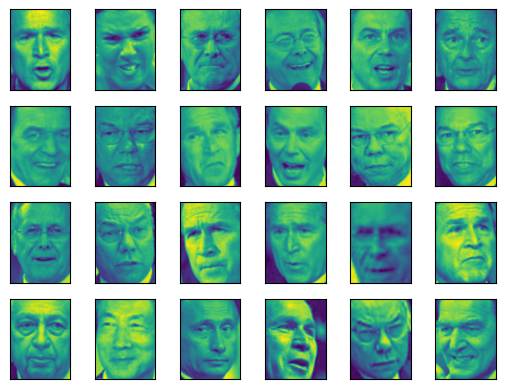

In [12]:
# Split dataset into train and test datasets
x_train, x_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.20,
                                                    stratify=y,
                                                    random_state=42)
# display examples
plt.figure(1)
figs, axes = plt.subplots(4, 6)
for i in range(4):
    for j in range(6):
        axes[i, j].imshow(x_train[i*6+j,:,:])
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])
plt.show()

In [13]:
# normalization
x_train = x_train.astype('float32')/255.0
x_test  = x_test.astype( 'float32')/255.0

# convert integer labesls to categorical vectors
y_train = to_categorical(y_train,nclasses)
y_test  = to_categorical(y_test, nclasses)

In [14]:
# baseline model
def baseline(W=32, H=32, nclass=10, nchannel=3,lr=1e-4):
    in1 = layers.Input(shape=(W, H, nchannel))
    x = layers.Conv2D(32, (3, 3), strides=(1, 1),
                      padding='valid',
                      activation='relu')(in1)
    x = layers.MaxPool2D((2, 2))(x)
    x=layers.BatchNormalization()(x)
    x = layers.Conv2D(32, (3, 3), strides=(1, 1),
                      padding='valid',
                      activation='relu')(x)
    x=layers.BatchNormalization()(x)
    x = layers.MaxPool2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), strides=(1, 1),
                      padding='valid',
                      activation='relu')(x)
    x = layers.MaxPool2D((2, 2))(x)
    x = layers.Flatten()(x)
    x = layers.Dropout(0.4)(x)
    # x = layers.Dense(128, activation='relu')(x)
    output = layers.Dense(nclass, activation='softmax')(x)
    model = Model(inputs=in1, outputs=output)
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizers.Adam(learning_rate=lr),
                  metrics=['acc'])
    return model

In [15]:
# 1- Baseline model
checkpoint_filepath2 = './checkpoints/checkpoint2.ckpt'
model_checkpoint_callback2 = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath2,
    save_weights_only=True,
    monitor='val_acc',
    mode='max',
    save_best_only=True)
#load model
model_base = baseline(W=W, H=H,nclass=nclasses,nchannel=nchannel,lr=1e-4)
model_base.summary()

# train model_base
history2 = model_base.fit(x_train,
                    y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[model_checkpoint_callback2],
                    validation_split=0.2,
                    verbose=False)#set verbose=True for monitoring epochs

# load model with best validation accuracy
model_base.load_weights(checkpoint_filepath2)
# evaluate model on the test dataset
test_loss2,test_acc2=model_base.evaluate(x_test,y_test)
print('test acc for model_base: ', test_acc2)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 125, 94, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 123, 92, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 61, 46, 32)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 61, 46, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 59, 44, 32)        9248      
                                                                 
 batch_normalization_1 (Bat  (None, 59, 44, 32)        128   

In [16]:
# 2- Model with ldp layer ----------------------------------------------------
def test_model1(W=32, H=32, nclass=10, nchannel=3,lr=1e-4):
    in1 = layers.Input(shape=(W, H,nchannel))
    x = layers.Conv2D(8, (3, 3), strides=(1, 1),
                      padding='valid',
                      activation='relu')(in1)
    #--------------------------------------
    x1 = LDP(mode='single', alpha='0' )(x)
    x2 = LDP(mode='single', alpha='45')(x)
    x3 = LDP(mode='single', alpha='90')(x)
    x4 = LDP(mode='single', alpha='135')(x)

    x1 = layers.Add()([x1,x])
    x2 = layers.Add()([x2,x])
    x3 = layers.Add()([x3,x])
    x4 = layers.Add()([x4,x])

    x = layers.Concatenate()([x1,x2,x3,x4])
    #--------------------------------------
    x = layers.MaxPool2D((2, 2))(x)
    x=layers.BatchNormalization()(x)

    x = layers.Conv2D(32, (3, 3), strides=(1, 1),
                      padding='valid',
                      activation='relu')(x)
    x=layers.BatchNormalization()(x)
    x = layers.MaxPool2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), strides=(1, 1),
                      padding='valid',
                      activation='relu')(x)
    x = layers.MaxPool2D((2, 2))(x)

    x = layers.Flatten()(x)


    x = layers.Dropout(0.4)(x)

    # x = layers.Dense(128, activation='relu')(x)
    output = layers.Dense(nclass, activation='softmax')(x)

    model = Model(inputs=in1, outputs=output)

    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizers.Adam(learning_rate=lr),
                  metrics=['acc'])
    return model


In [19]:
# Model with ldp layer ----------------------------------------------------
checkpoint_filepath1 = './checkpoints/checkpoint1.ckpt'
model_checkpoint_callback1 = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath1,
    save_weights_only=True,
    monitor='val_acc',
    mode='max',
    save_best_only=True)

#load model
model_ldp  = test_model1(W=W, H=H,nclass=nclasses,nchannel=nchannel,lr=1e-4)
model_ldp.summary()

# train model_ldp
history1 = model_ldp.fit(x_train,
                    y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[model_checkpoint_callback1],
                    validation_split=0.2,
                    verbose=False)#set verbose=True for monitoring epochs

# load model with best validation accuracy
model_ldp.load_weights(checkpoint_filepath1)

# evaluate model on the test dataset
test_loss1,test_acc1=model_ldp.evaluate(x_test,y_test)
print('test acc for model_ldp : ', test_acc1)

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 125, 94, 1)]         0         []                            
                                                                                                  
 conv2d_9 (Conv2D)           (None, 123, 92, 8)           80        ['input_4[0][0]']             
                                                                                                  
 ldp_8 (LDP)                 (None, 123, 92, 8)           0         ['conv2d_9[0][0]']            
                                                                                                  
 ldp_9 (LDP)                 (None, 123, 92, 8)           0         ['conv2d_9[0][0]']            
                                                                                            

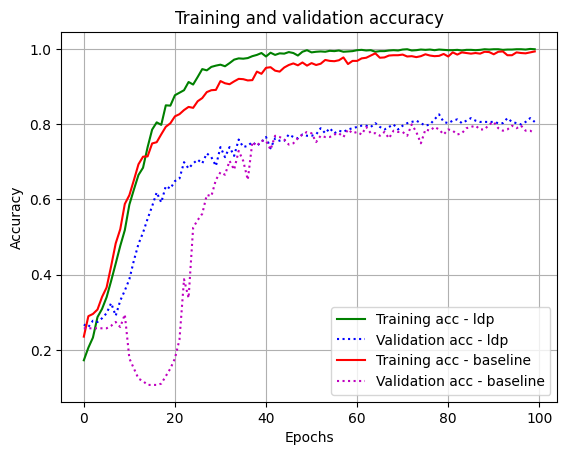

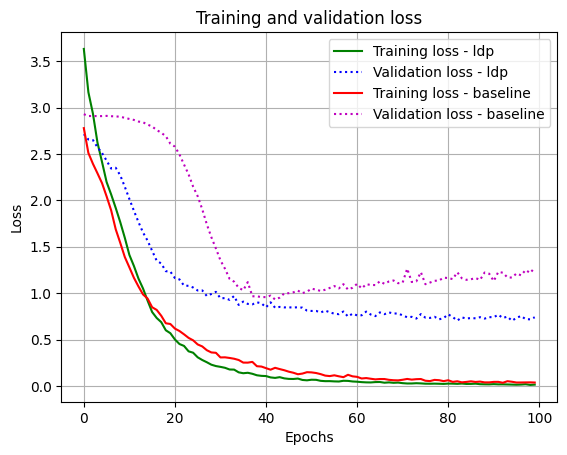

In [20]:
# plot accuracy and loss graphs
# model_ldp
acc1      = history1.history['acc']
val_acc1  = history1.history['val_acc']
loss1     = history1.history['loss']
val_loss1 = history1.history['val_loss']
# model_base
acc2      = history2.history['acc']
val_acc2  = history2.history['val_acc']
loss2     = history2.history['loss']
val_loss2 = history2.history['val_loss']

plt.figure(2)
epochs = range(len(acc1))
plt.plot(epochs, acc1,     'g', label='Training acc - ldp')
plt.plot(epochs, val_acc1, 'b:',label='Validation acc - ldp')
plt.plot(epochs, acc2,     'r', label='Training acc - baseline')
plt.plot(epochs, val_acc2, 'm:',label='Validation acc - baseline')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()
plt.show()

plt.figure(3)
plt.plot(epochs, loss1,     'g',  label='Training loss - ldp')
plt.plot(epochs, val_loss1, 'b:', label='Validation loss - ldp')
plt.plot(epochs, loss2,     'r',  label='Training loss - baseline')
plt.plot(epochs, val_loss2, 'm:', label='Validation loss - baseline')
plt.title( 'Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()
